In [1]:
import numpy as np
import pandas as pd
import time
import seaborn as sns
import matplotlib.pyplot as plt

# Pré Processamento dos Dados
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, Normalizer

# Métricas
from sklearn.metrics import confusion_matrix

# Seleção de features
from sklearn.feature_selection import SelectKBest, f_classif

from sklearn.model_selection import train_test_split

# Modelos Classificadores
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier


from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split, StratifiedKFold
    
import warnings
warnings.filterwarnings('ignore')

In [2]:
pathWineQuality = 'dataSets/winequality.csv'

## Análise inicial dos Dados

In [3]:
dfWineQuality = pd.read_csv(pathWineQuality, sep=';')
dfWineQuality.head(5)

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,White,7.0,0.27,0.36,20.7,45.00,45.0,170.0,1001.0000,3.00,0.45,8.8,6
1,White,6.3,0.30,0.34,1.6,49.00,14.0,132.0,994.0000,3.30,0.49,9.5,6
2,White,8.1,0.28,0.40,6.9,0.05,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,White,7.2,0.23,0.32,8.5,58.00,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,White,7.2,0.23,0.32,8.5,58.00,47.0,186.0,0.9956,3.19,0.40,9.9,6


#### Dados duplicados são removidos do DataSet. O esse tipo de "sujeira" em grande quantidade pode causar o problema de overfitting no modelo

In [4]:
print('Existem {} itens Duplicados e que foram removidos do DataSet'.format(dfWineQuality.duplicated(keep='first').sum()))
dfWineQuality = dfWineQuality.drop_duplicates(keep='first')

Existem 1177 itens Duplicados e que foram removidos do DataSet


#### Agora vamos dar uma olhada geral nas informações existentes no DataSet atráves da função describe() do DataFrame

In [5]:
dfWineQuality.describe(include='all')

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,5320,5320.000000,5320.000000,5320.000000,5320.000000,5320.000000,5320.000000,5320.000000,5320.000000,5320.000000,5320.000000,5.320000e+03,5320.000000
unique,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,White,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,3961,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,7.215179,31.731883,0.318494,5.048477,50.145648,30.036654,114.109023,764.416844,3.224664,0.533357,1.790965e+12,5.795677
std,NaN,1.319671,140.260076,0.147157,4.500180,38.628993,17.805045,56.774223,7582.034279,0.160379,0.149743,3.552818e+13,0.879772
min,NaN,3.800000,0.080000,0.000000,0.600000,0.020000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000e+00,3.000000
25%,NaN,6.400000,0.230000,0.240000,1.800000,34.000000,16.000000,74.000000,0.992400,3.110000,0.430000,9.500000e+00,5.000000
50%,NaN,7.000000,0.300000,0.310000,2.700000,45.000000,28.000000,116.000000,0.994980,3.210000,0.510000,1.040000e+01,6.000000
75%,NaN,7.700000,0.430000,0.400000,7.500000,62.000000,41.000000,153.250000,0.997200,3.330000,0.600000,1.140000e+01,6.000000


#### Podemos obsevar que a feature 'Alcohol' que (intuĩtivamente) apresenta o teor alcoolico da bebida possuem valores que fogem a realidade (acima de 100% de alcool na bebida). O primeiro passo é verificar a quantidade de registros que apresentam essa distorção e avaliar se terá um impacto muito significativo no dataset para o caso de remoção.

In [6]:
totalRegAlc= len(dfWineQuality[dfWineQuality['alcohol'] > 100])
print('Existem {0} registro com teor alcoolico acima 100%, que corresponde a {1:.1f}% de todos os registros do DataSet'.format(totalRegAlc, totalRegAlc/dfWineQuality['alcohol'].count()*100))

Existem 32 registro com teor alcoolico acima 100%, que corresponde a 0.6% de todos os registros do DataSet


#### Como a significancia dos registros é pequena em comparação com a proporção do DataSet, esses registros serão removidos.

In [7]:
dfWineQuality.drop(dfWineQuality[dfWineQuality['alcohol'] > 100].index, inplace=True)

### O próximo passo é dar uma olhada nos registro como um todo. O objetivo é tentar identificar valores que possam comprometer o resultado final do modelo

#### Em seguida é feira uma separação dos dados númericos e realizado um ajuste de padronizão para facilitar a análise.

In [13]:
dataNumbers = dfWineQuality.drop(['type', 'quality'], axis=1)

scaler = StandardScaler()
dataNumbersStd = scaler.fit_transform(dataNumbers)

dataNumbersStd = pd.DataFrame(dataNumbersStd, columns=dataNumbers.columns, index=dataNumbers.index)
dataNumbersStd.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
count,5.288000e+03,5.288000e+03,5.288000e+03,5.288000e+03,5.288000e+03,5.288000e+03,5.288000e+03,5.288000e+03,5.288000e+03,5.288000e+03,5.288000e+03
mean,9.235762e-17,4.420212e-16,1.149358e-15,-1.738765e-15,-4.229786e-16,4.448870e-17,-3.906356e-16,-4.595836e-17,1.129539e-17,-1.849252e-16,3.004090e-16
std,1.000095e+00,1.000095e+00,1.000095e+00,1.000095e+00,1.000095e+00,1.000095e+00,1.000095e+00,1.000095e+00,1.000095e+00,1.000095e+00,1.000095e+00
min,-2.592643e+00,-2.248378e-01,-2.163092e+00,-9.877977e-01,-1.295770e+00,-1.628020e+00,-1.900692e+00,-1.010061e-01,-3.146179e+00,-2.091489e+00,-2.147520e+00
25%,-6.214523e-01,-2.237665e-01,-5.340437e-01,-7.214649e-01,-4.178673e-01,-7.864677e-01,-7.044313e-01,-1.010054e-01,-6.682929e-01,-6.894360e-01,-8.827226e-01
50%,-1.665622e-01,-2.232666e-01,-5.890462e-02,-5.217153e-01,-1.336729e-01,-1.132256e-01,3.443561e-02,-1.010050e-01,-9.167794e-02,-1.553207e-01,-1.238440e-01
75%,3.641429e-01,-2.223382e-01,5.519885e-01,5.436159e-01,3.055366e-01,6.161202e-01,6.853422e-01,-1.010048e-01,6.563631e-01,4.455590e-01,7.193545e-01
max,6.580974e+00,8.237367e+00,9.104492e+00,1.348295e+01,1.448942e+01,1.452979e+01,5.734266e+00,1.356248e+01,4.895262e+00,9.792577e+00,3.670549e+00


#### Na célula abaixo temos um gráfico do tipo BoxPlot que permite visualizarmos a distribuição dos dados. É um gráfico interessante por que nele podemos identificar possíveis outlier (registros que estão foram da distribuição padrao dos dados) no DataSet, o que nos permite uma tomada de decisão adequada.

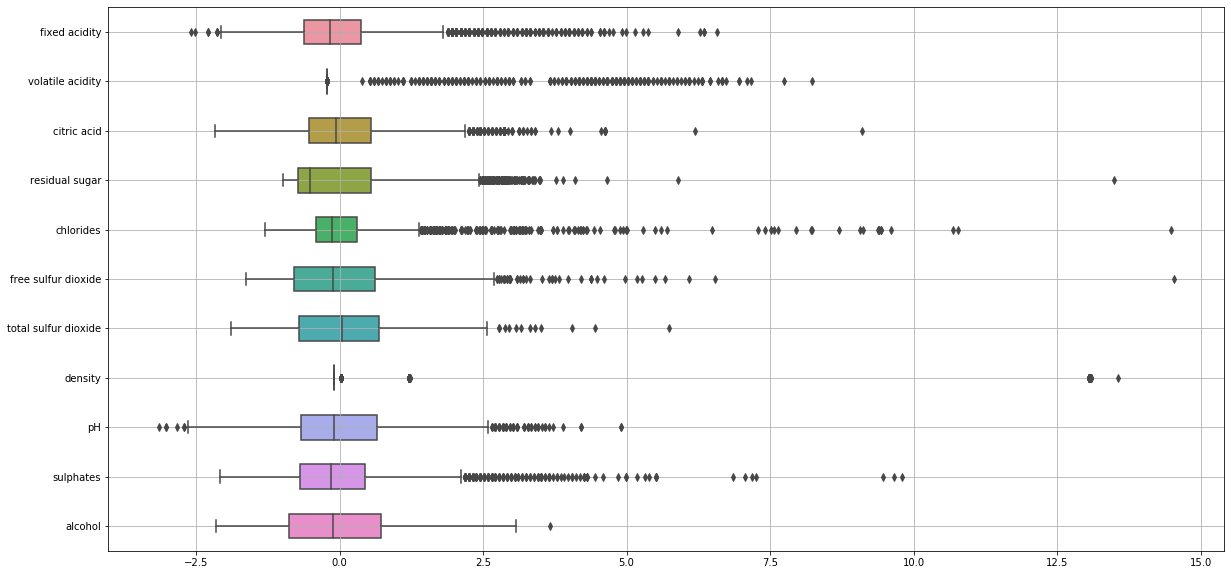

In [14]:
plt.figure(figsize=(20,10))
sns.boxplot(data=dataNumbersStd, orient='h', width=0.5, )
# dataNumbersStd.boxplot(figsize=(20,10), vert=False)
plt.grid()
plt.show()

#### Observando o gráfico podemos observar que várias features possuem bastantes outliers e o comportamento desses registros distoam em cada features. Como são muitos e a remoção de todos implicaria em afetar diretamente outras features, foi decido remover somente os outliers que estão fora dos limites inferior e superior (esq. e dir.) da feature com o maior range.

#### A baixo é realizada a remoção dos registros que contenham em algumas de suas features valores menores que -2.5 e maiores que 3.1

In [15]:
dataNumbersStd = dataNumbersStd[(dataNumbersStd > -2.5) & (dataNumbersStd < 3.1)]
rowsWithNaNValue = dataNumbersStd[dataNumbersStd.isnull().any(axis=1)].index
dataNumbersStd = dataNumbersStd[~dataNumbersStd.isnull().any(axis=1)]

#### O novo BoxPlot ainda possue outliers, no entanto em quantidades bem menores o que esperamos que não afeta o modelo.

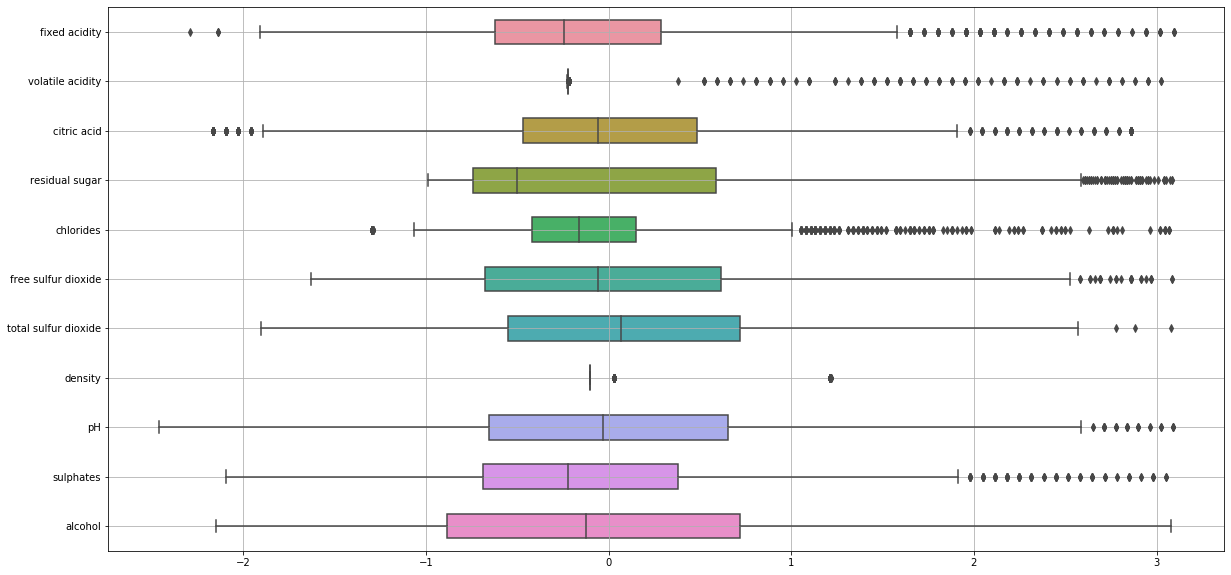

In [16]:
plt.figure(figsize=(20,10))
sns.boxplot(data=dataNumbersStd, orient='h', width=0.5, )
plt.grid()
plt.show()

In [17]:
dfWineQuality.drop(list(rowsWithNaNValue), inplace=True)

#### Analise sobre qualidade do vinho. Seguida são geradas algumas informações que possibilitem ter algum inside sobre o dataset.

In [18]:
gpWineQualityTypes = dfWineQuality.groupby('type')['type'].count()

In [19]:
print('A distribuição de vinhos ficou da seguinte forma:\n{0:.0f}% dos vinhos são Brancos\n{1:.0f}% são vermelhos'.format(gpWineQualityTypes[1] / gpWineQualityTypes.sum() *100, gpWineQualityTypes[0] / gpWineQualityTypes.sum() *100))

A distribuição de vinhos ficou da seguinte forma:
78% dos vinhos são Brancos
22% são vermelhos


In [25]:
print('O score médio de qualidade recebido pelos vinhos Vermelhos e Brancos é respectivamente, {0} e {1}'.format(dfWineQuality.groupby('type')['quality'].median()[0], dfWineQuality.groupby('type')['quality'].median()[1]))

O score médio de qualidade recebido pelos vinhos Vermelhos e Brancos é respectivamente, 6 e 6


#### Em seguida é feita uam categorização da feature 'Type' que é nominal para torna-lá númerica

In [27]:
dfWineQuality.type = dfWineQuality.type.astype('category').cat.codes
dfWineQuality.describe()

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,4796.000000,4796.000000,4796.000000,4796.000000,4796.000000,4796.000000,4796.000000,4796.000000,4796.000000,4796.000000,4796.000000,4796.000000,4796.000000
mean,0.784195,7.095236,6.542000,0.315619,5.063782,45.623543,30.401585,116.788782,140.933131,3.224735,0.520438,10.586827,5.827148
std,0.411422,1.087618,43.754534,0.132634,4.316416,26.418749,16.425003,54.325079,892.381551,0.152978,0.127713,1.189878,0.875540
min,0.000000,4.200000,0.080000,0.000000,0.600000,0.020000,1.000000,6.000000,0.987110,2.830000,0.220000,8.000000,3.000000
25%,1.000000,6.400000,0.230000,0.250000,1.700000,34.000000,18.000000,82.750000,0.992200,3.120000,0.430000,9.500000,5.000000
50%,1.000000,6.900000,0.290000,0.310000,2.800000,44.000000,29.000000,118.000000,0.994740,3.220000,0.500000,10.400000,6.000000
75%,1.000000,7.600000,0.400000,0.390000,7.700000,56.000000,41.000000,155.000000,0.996900,3.330000,0.590000,11.400000,6.000000
max,1.000000,11.300000,455.000000,0.740000,18.950000,169.000000,85.000000,289.000000,10026.000000,3.720000,0.990000,14.200000,9.000000


### Definindo o Modelo

#### Análisando o problema proposto, compreendo que se trata de uma tarefa de classificação. A partir desse entendimento inicial, a abordagem adotada propõem avaliar alguns modelos de classificação e trabalhar de fato com aquele que melhor se sair diante do cenário proposto.

#### Funções

In [28]:
def KBestTable(sel, df, features):
  #Função para ranquear os atributos de um dataset.
  names = df[features].columns.values[sel.get_support()]
  scores = pd.Series(sel.scores_, names).sort_values(ascending=False)
  return scores

In [37]:
def executeModelsClfs(clf, param, x_train, x_test, y_train, y_test):

    skb = {'sel__k': ['all'] + list(range(3,len(data.columns),3))}
    param.update(skb)
    
    # Construção do pipeLine
    cv = StratifiedKFold(n_splits=5, random_state=seed)
    pipe = Pipeline(steps=[('sel', SelectKBest()), ('clf', clf)]) 
#     metricas = ['recall_weighted', 'r2', 'f1_weighted']

    # iniciando o Treino
    timeStartModel = time.time()
    
    model = GridSearchCV(pipe, param_grid=param, cv=cv, scoring='recall_weighted')
    model.fit(x_train, y_train)
    
    timeEndModel = time.time()
    time_trainer= timeEndModel-timeStartModel
                     
    best_score = model.best_score_
    best_model = model.best_estimator_

    #  Iniciando os Testes
    timeStartModel = time.time()              
    pred = best_model.predict(x_test)
    timeEndModel = time.time()
    time_test = timeEndModel-timeStartModel
    
    # Print dos principais resultados da função                 
    print(clf.__class__.__name__) # Nome do classificador
    print("--------------------\n")
    print("Tempo de Treino: {0} minutos.\nTempo de Teste: {1} minutos".format(time_trainer/60, time_test/60))
    print("Melhor Recall-score no treino: {}".format(best_score))
    print("Recall-score no Teste foi: {}".format(model.score(x_test, y_test)))
    print("\n\n")
    
    #Lista com os principais resultados
    resultado = {'nome':clf.__class__.__name__,
                 'tempo_treino':time_trainer/60,
                 'best_score': best_score,
                 'score_test':model.score(x_test, y_test)
                }
    
    return resultado, best_model

#### A baixo é definido uma semente aleatória para garantir reproducibilidade do processo e logo em seguida o DataSet é separado em Dados (x) e Target (y).

In [31]:
seed = 0
data = dfWineQuality.drop(['quality'], axis=1)
target = dfWineQuality.quality

#### Utilizou-se o módulo SelectKBest para ordenar as colunas por importância em relação a qualidade e, podemos observar que "alcohol", "density" e "chlorides" são as mais importantes para qualidade.

In [30]:
sel = SelectKBest(f_classif, k = 'all').fit(data, target)
KBestTable(sel, data, data.columns)

alcohol                 285.255249
chlorides                28.436996
free sulfur dioxide      14.063465
type                     12.558040
residual sugar            9.967804
total sulfur dioxide      9.194446
fixed acidity             8.689621
citric acid               6.327230
sulphates                 5.465878
pH                        3.449232
density                   1.478354
volatile acidity          0.131517
dtype: float64

In [38]:
# Modelos a serem testados
clf1 = GaussianNB()
clf2 = DecisionTreeClassifier(random_state=seed)
clf3 = RandomForestClassifier(random_state=seed)
clf4 = MLPClassifier(random_state=seed)
clf5 = KNeighborsClassifier()
clf6 = SVC(random_state=seed)
clf7 = LogisticRegression()

# Parâmetros por modelo
prm1 = {}
prm2 = {'clf__max_depth':[None, 5, 10],'clf__min_samples_leaf':[1,20,50]}
prm3 = {'clf__n_estimators':[10,50,100],'clf__max_depth':[None, 5, 10],'clf__min_samples_leaf':[1,20,50]}
prm4 = {'clf__learning_rate_init':[0.001, 0.01], 'clf__max_iter':[200,500]}
prm5 = {'clf__n_neighbors': [3,5,10], 'clf__weights':['uniform', 'distance']}
prm6 = {'clf__C':[1,0.5], 'clf__shrinking':[False, True]}
prm7 = {'clf__solver':['sag'],'clf__multi_class':['multinomial'], 'clf__max_iter': [3,7]}

# Split do DataSet em treino e teste
x_train, x_test, y_train, y_test = train_test_split(data, target, stratify=target, test_size=0.2, random_state=seed)


summary = []
models = {}

for clf, prm in [[clf1,prm1], [clf2,prm2],[clf3,prm3],[clf4,prm4],
                 [clf5,prm5],[clf6,prm6],[clf7,prm7]]:
  results, model = executeModelsClfs(clf, prm, x_train, x_test, y_train, y_test)
  summary.append(results)
  models[results['nome']] = model

GaussianNB
--------------------

Tempo de Treino: 0.002250480651855469 minutos.
Tempo de Teste: 1.4674663543701171e-05 minutos
Melhor Recall-score no treino: 0.502606882168926
Recall-score no Teste foi: 0.503125



DecisionTreeClassifier
--------------------

Tempo de Treino: 0.03406692743301391 minutos.
Tempo de Teste: 1.1305014292399088e-05 minutos
Melhor Recall-score no treino: 0.5216371220020855
Recall-score no Teste foi: 0.5208333333333334



RandomForestClassifier
--------------------

Tempo de Treino: 1.1647995551427206 minutos.
Tempo de Teste: 0.00032928387324015297 minutos
Melhor Recall-score no treino: 0.5623044838373306
Recall-score no Teste foi: 0.5552083333333333



MLPClassifier
--------------------

Tempo de Treino: 0.722383451461792 minutos.
Tempo de Teste: 2.3412704467773438e-05 minutos
Melhor Recall-score no treino: 0.4773201251303441
Recall-score no Teste foi: 0.484375



KNeighborsClassifier
--------------------

Tempo de Treino: 0.0413729190826416 minutos.
Tempo de

In [39]:
ordenado = ['nome', 'best_score', 'score_test', 'tempo_treino']
pd.DataFrame(summary, columns=ordenado)\
  .sort_values('score_test', ascending=False)

,nome,best_score,score_test,tempo_treino
2,RandomForestClassifier,0.562304,0.555208,1.164800
1,DecisionTreeClassifier,0.521637,0.520833,0.034067
0,GaussianNB,0.502607,0.503125,0.002250
3,MLPClassifier,0.477320,0.484375,0.722383
6,LogisticRegression,0.466893,0.469792,0.008545
5,SVC,0.471324,0.454167,1.278624
4,KNeighborsClassifier,0.456726,0.445833,0.041373


#### Acima temos uma tabela que sumariza os resultados. O modelo RandomForest teve o melhor resultado seguido pelo DecisionTreeClassifier. Entretanto o tempo de execução do entre o RandomForest (~ 1.16 min) e DecisionTreeClassifier (~ 0.03 min) é bastante significativo. Considerando o Tempo de treinamento do modelo e valor obtido como fator determinante o modelo escolhido para a tarefa deverá ser o DecisionTreeClassifier.